# Hamiltonian Monte Carlo

**The code for this tutorial was taken from Colin Carroll's excellent blog post, [Hamiltonian Monte Carlo from Scratch](https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/)**

While flexible and easy to implement, Metropolis-Hastings sampling is a random walk
sampler that might not be statistically efficient for many models. Specifically, for models of high dimension, random walk jumping algorithms do not perform well. It is not enough to simply guess at the next sample location; we need to make each iteration a useful draw from the posterior whenever we can, in order to have an efficient sampler for bigger models.

Since Bayesian inference is all about calculating expectations over posteriors, what we seek is an algorithm that explores the area of the parameter space that contains most of the non-zero probability. This region is called the **typical set**.

### What's a Typical Set?

The typical set is where most of the probability density (mass) lies in a particular volume associated with the distribution. As the dimension of a model increases, this set moves progressively further from the mode, and becomes more singular, as the result of concentration of measure.

The typical set is a product of both the density, which is highest at the mode, and volume (that we integrate over), which increasingly becomes larger away from the mode as dimensionality increases. In fact, at high dimensions, the region around the mode contributes almost nothing to the expectation. We need an algorithm that will find this narrow region and explore it efficiently.

![from Hoffman and Gelman 2014](http://d.pr/i/RAA+)

In this context, and when sampling from continuous variables, Hamiltonian (or Hybrid) Monte
Carlo (HMC) can prove to be a powerful tool. It avoids
random walk behavior by simulating a physical system governed by
Hamiltonian dynamics, potentially avoiding tricky conditional
distributions in the process.

## Pictures of what's going on


### Hamiltonian trajectories
Starting from any point, we can generate a new sample from a probability distribution by giving the point some momentum and then updating the position and momentum according to a certain system of differential equations (Hamilton's equations, whence the name). The differential equation depends on the probability distribution, and we update the position and momentum using "leapfrog integration". Here are three trajectories of a 2d multivariate normal. 

<img src='../images/normal_leapfrog.png'/>

Calculating these trajectories is expensive, and we will do a lot of work to make this less expensive. Sometimes trajectories are not precisely ellipses. Here are three trajectories for a mixture of three normal distributions.

<img src='../images/mixture_leapfrog.png'/>

Notice that the Hamiltonian dynamics preserve energy: the momentum is indicated by the size and direction of the arrows; when the trajectory is furthest away from one of the modes, the arrows are very small indicating large potential energy and small kinetic energy. There is also one trajectory that stays very close to a single mode because it does not have the energy to move to another.

### Hamiltonian Monte Carlo

Once we can generate these Hamiltonian trajectories, we fix an integration length, generate a trajectory of that length, and that is our next sample. Starting from that point, we pick a new momentum at random, and keep going. Here is an example of 10 draws from a 2D multivariate Gaussian with 3 different path lengths.

<img src='../images/normal_hmc.png'/>

Notice that each trajectory starts from where the previous trajectory ended, but the momentum is totally different. In reality, we will make a much cruder estimate of the trajectory to save computing time, and accept or reject the proposal at the end of the trajectory, usually aiming to accept 60-80% of the time.

Here also are trajectories for a mixture of 3 multivariate normals, again with 3 different path lengths.

<img src='../images/mixture_hmc.png'/>

Notice that mixing between modes can be hard, and can take time! The path length of 2 never makes it to a different mode! Of course, this is only drawing 10 samples, but it is something to keep in mind while tuning an HMC sampler.

## Hamiltonian Monte Carlo: The Math

In HMC, model samples are obtained by simulating a physical system,
where particles move about a high-dimensional landscape, subject to
potential and kinetic energies. Adapting the notation from [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html),
particles are characterized by a position vector or state
$s \in \mathcal{R}^D$ and velocity vector $\phi \in \mathcal{R}^D$. The
combined state of a particle is denoted as $\chi=(s,\phi)$. 

The joint **canonical distribution** of the position and velocity can be expressed as a product of the marginal position (which is of interest) and the conditional distribution of the velocity:

$$\pi(s, \phi) = \pi(\phi | s) \pi(s)$$

This joint probability can also be written in terms of an invariant **Hamiltonian function**:

$$\pi(s, \phi) \propto \exp(-H(s,\phi))$$

The Hamiltonian is then defined as the sum of potential energy $E(s)$ and kinetic energy
$K(\phi)$, as follows:

$$\mathcal{H}(s,\phi) = E(s) + K(\phi)
= E(s) + \frac{1}{2} \sum_i \phi_i^2$$

Instead of sampling $p(s, \phi)$ directly, HMC operates by sampling from the canonical distribution.

$$p(s,\phi) = \frac{1}{Z} \exp(-\mathcal{H}(s,\phi))=p(s)p(\phi)$$.

If we choose a momentum that is independent of position, marginalizing over $\phi$ is
trivial and recovers the original distribution of interest.

Note that the Hamiltonian $\mathcal{H}$ is independent of the parameterization of the model, and therefore, captures the geometry of the phase space distribution, including typical set. 

**Hamiltonian Dynamics**

State $s$ and velocity $\phi$ are modified such that
$\mathcal{H}(s,\phi)$ remains constant throughout the simulation. The
differential equations are given by:

$$\begin{aligned}\frac{ds_i}{dt} &= \frac{\partial \mathcal{H}}{\partial \phi_i} = \phi_i \\
\frac{d\phi_i}{dt} &= - \frac{\partial \mathcal{H}}{\partial s_i}
= - \frac{\partial E}{\partial s_i}
\end{aligned}$$

As shown in [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html), 
the above transformation preserves volume and is
reversible. The above dynamics can thus be used as transition operators
of a Markov chain and will leave $p(s,\phi)$ invariant. That chain by
itself is not ergodic however, since simulating the dynamics maintains a
fixed Hamiltonian $\mathcal{H}(s,\phi)$. HMC thus alternates Hamiltonian
dynamic steps, with Gibbs sampling of the velocity. Because $p(s)$ and
$p(\phi)$ are independent, sampling $\phi_{new} \sim p(\phi|s)$ is
trivial since $p(\phi|s)=p(\phi)$, where $p(\phi)$ is often taken to be
the univariate Gaussian.

**The Leap-Frog Algorithm**

In practice, we cannot simulate Hamiltonian dynamics exactly because of
the problem of time discretization. There are several ways one can do
this. To maintain invariance of the Markov chain however, care must be
taken to preserve the properties of *volume conservation* and *time
reversibility*. The **leap-frog algorithm** maintains these properties
and operates in 3 steps:

$$\begin{aligned}
\phi_i(t + \epsilon/2) &= \phi_i(t) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t)) \\
s_i(t + \epsilon) &= s_i(t) + \epsilon \phi_i(t + \epsilon/2) \\
\phi_i(t + \epsilon) &= \phi_i(t + \epsilon/2) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t + \epsilon)) 
\end{aligned}$$

We thus perform a half-step update of the velocity at time
$t+\epsilon/2$, which is then used to compute $s(t + \epsilon)$ and
$\phi(t + \epsilon)$.

Here is an implementation from [`minimc`](https://github.com/ColCarroll/minimc):

```python

def leapfrog(q, p, dVdq, path_len, step_size):
    """Leapfrog integrator for Hamiltonian Monte Carlo.

    Parameters
    ----------
    q : np.floatX
        Initial position
    p : np.floatX
        Initial momentum
    dVdq : callable
        Gradient of the velocity
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be

    Returns
    -------
    q, p : np.floatX, np.floatX
        New position and momentum
    """
    q, p = np.copy(q), np.copy(p)

    p -= step_size * dVdq(q) / 2  # half step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        p -= step_size * dVdq(q)  # whole step
    q += step_size * p  # whole step
    p -= step_size * dVdq(q) / 2  # half step

    # momentum flip at end
    return q, -p
```

**Accept / Reject**

In practice, using finite stepsizes $\epsilon$ will not preserve
$\mathcal{H}(s,\phi)$ exactly and will introduce bias in the simulation.
Also, rounding errors due to the use of floating point numbers means
that the above transformation will not be perfectly reversible.

HMC cancels these effects **exactly** by adding a Metropolis
accept/reject stage, after $n$ leapfrog steps. The new state
$\chi' = (s',\phi')$ is accepted with probability $p_{acc}(\chi,\chi')$,
defined as:

$$p_{acc}(\chi,\chi') = min \left( 1, \frac{\exp(-\mathcal{H}(s',\phi')}{\exp(-\mathcal{H}(s,\phi)} \right)$$

**HMC Algorithm**

We obtain a new HMC sample as follows:

1.  sample a new velocity from a univariate Gaussian distribution
2.  perform $n$ leapfrog steps to obtain the new state $\chi'$
3.  perform accept/reject move of $\chi'$

The `minimc` implementation of the HMC algorithm:

```python
from autograd import grad
import autograd.numpy as np
import scipy.stats as st


def hamiltonian_monte_carlo(n_samples, negative_log_prob, initial_position, path_len=1, step_size=0.5):
    """Run Hamiltonian Monte Carlo sampling.

    Parameters
    ----------
    n_samples : int
        Number of samples to return
    negative_log_prob : callable
        The negative log probability to sample from
    initial_position : np.array
        A place to start sampling from.
    path_len : float
        How long each integration path is. Smaller is faster and more correlated.
    step_size : float
        How long each integration step is. Smaller is slower and more accurate.

    Returns
    -------
    np.array
        Array of length `n_samples`.
    """    
    # autograd magic
    dVdq = grad(negative_log_prob)

    # collect all our samples in a list
    samples = [initial_position]

    # Keep a single object for momentum resampling
    momentum = st.norm(0, 1)

    # If initial_position is a 10d vector and n_samples is 100, we want 100 x 10 momentum draws
    # we can do this in one call to np.random.normal, and iterate over rows
    size = (n_samples,) + initial_position.shape[:1]
    for p0 in momentum.rvs(size=size):
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog(
            samples[-1],
            p0,
            dVdq,
            path_len=path_len,
            step_size=step_size,
        )

        # Check Metropolis acceptance criterion
        start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_log_p = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        if np.log(np.random.rand()) < start_log_p - new_log_p:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))

    return np.array(samples[1:])

```

Now, let's see the code in action

## Leapfrog Integration

In [2]:
from autograd import grad
import autograd.numpy as np
import matplotlib.pyplot as plt

# Using code from https://github.com/ColCarroll/minimc/tree/e6948430447ec94240568540d42405a51d3aca26
from minimc.minimc_slow import leapfrog, hamiltonian_monte_carlo
from minimc import neg_log_mvnormal

In [18]:
# Plotting helper function
def neg_log_p_to_img(neg_log_p, extent=None, num=100):
    if extent is None:
        extent = (-3, 3, -3, 3)
    X, Y = np.meshgrid(np.linspace(*extent[:2], num), np.linspace(*extent[2:], num))
    Z = np.array([np.exp(-neg_log_p(j)) for j in np.array((X.ravel(), Y.ravel())).T]).reshape(X.shape)
    return Z, extent

### Example: Bivariate normal leapfrog integrations

In [5]:
np.random.seed(1)

neg_log_p = neg_log_mvnormal(np.zeros(2), np.eye(2))
dVdq = grad(neg_log_p)

positions, momentums = [], []
for _ in range(3):
    q, p = np.random.randn(2, 2)
    _, _, q, p = leapfrog(q, p, dVdq, 2 * np.pi, 0.01)
    positions.append(q)
    momentums.append(p)

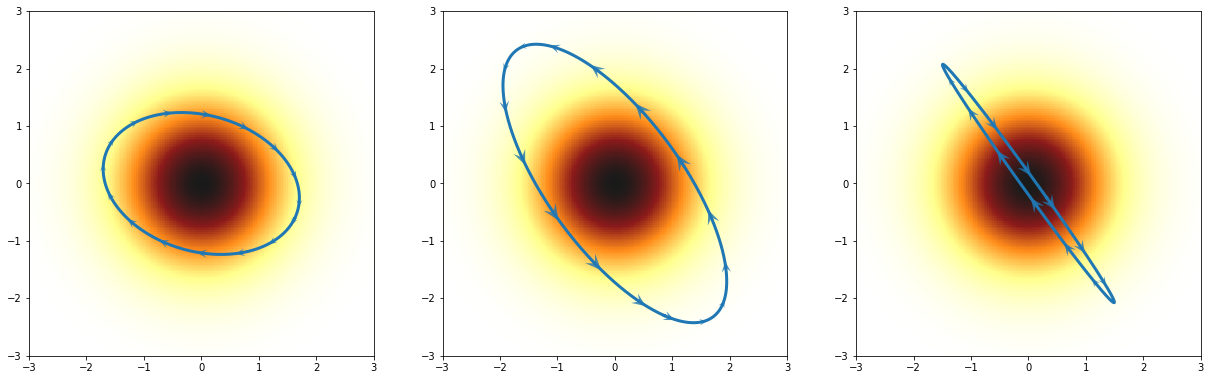

In [6]:
fig, axes = plt.subplots(ncols=len(positions), figsize=(7 * len(positions), 7))


steps = slice(None, None, 40)

Z, extent = neg_log_p_to_img(neg_log_p, (-3, 3, -3, 3), num=200)

for idx, (ax, q, p) in enumerate(zip(axes.ravel(), positions, momentums)):
    ax.imshow(Z, alpha=0.9, extent=extent, cmap='afmhot_r', origin='top')

    ax.quiver(q[steps, 0], q[steps, 1], p[steps, 0], p[steps, 1], headwidth=6, scale=60, headlength=7, alpha=0.8, color='C0')
    ax.plot(q[:, 0], q[:, 1], '-', lw=3, color='C0')


### Example: Normal mixture distribution

In [7]:
from minimc import mixture, neg_log_mvnormal

np.random.seed(7)

mu1 = np.ones(2)
cov1 = 0.5 * np.array([[1., 0.7],
                       [0.7, 1.]])
mu2 = -mu1
cov2 = 0.2 * np.array([[1., -0.6],
                       [-0.6, 1.]])

mu3 = np.array([-1., 2.])
cov3 = 0.3 * np.eye(2)

neg_log_p = mixture([neg_log_mvnormal(mu1, cov1), neg_log_mvnormal(mu2, cov2), neg_log_mvnormal(mu3, cov3)], [0.3, 0.3, 0.4])
dVdq = grad(neg_log_p)


positions, momentums = [], []
for _ in range(3):
    q, p = np.random.randn(2, 2)
    _, _, q, p = leapfrog(q, p, dVdq, 4 * np.pi, 0.01)
    positions.append(q)
    momentums.append(p)

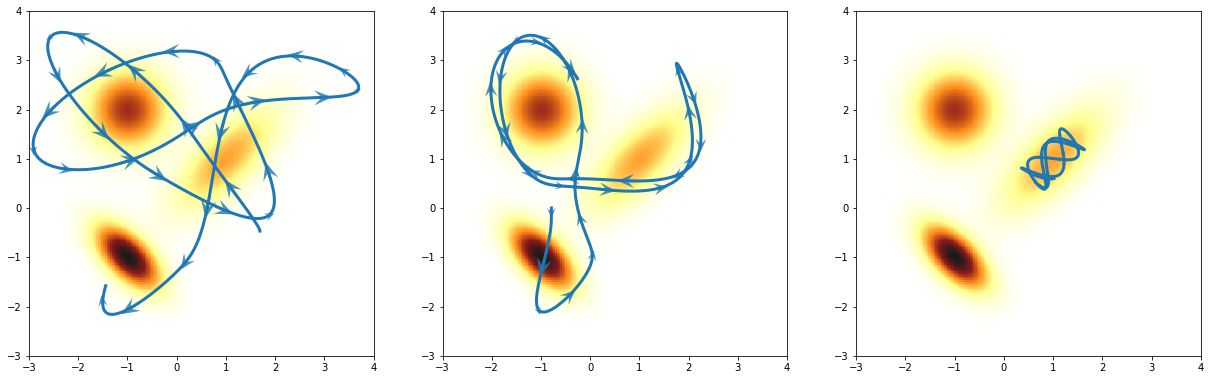

In [8]:
fig, axes = plt.subplots(ncols=len(positions), figsize=(7 * len(positions), 7))


steps = slice(None, None, 40)

Z, extent = neg_log_p_to_img(neg_log_p, (-3, 4, -3, 4), num=200)

for idx, (ax, q, p) in enumerate(zip(axes.ravel(), positions, momentums)):
    ax.imshow(Z, alpha=0.9, extent=extent, cmap='afmhot_r', origin='top')

    ax.quiver(q[steps, 0], q[steps, 1], p[steps, 0], p[steps, 1], headwidth=6, scale=60, headlength=7, alpha=0.8, color='C0')
    ax.plot(q[:, 0], q[:, 1], '-', lw=3, color='C0')


## Hamiltonian Monte Carlo

### Example: Bivariate normal 

In [9]:
np.random.seed(4)

neg_log_p = neg_log_mvnormal(np.zeros(2), np.eye(2))
ss, pp, mm, pl = [], [], [], [1, 2, 4]
for path_len in pl:
    samples, positions, momentums, accepted = hamiltonian_monte_carlo(10, neg_log_p, np.random.randn(2), path_len=path_len, step_size=0.01)
    ss.append(samples)
    pp.append(positions)
    mm.append(momentums)

100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


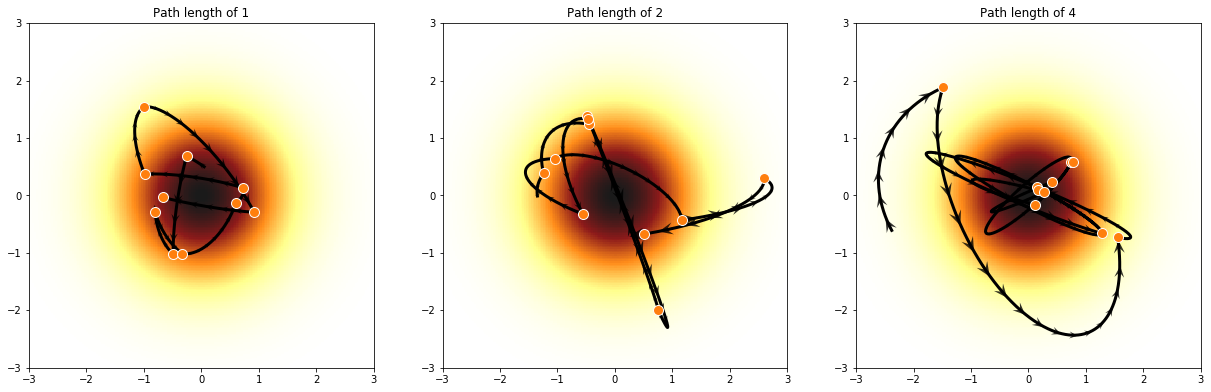

In [10]:
fig, axes = plt.subplots(ncols=len(ss), figsize=(7 * len(ss), 7))

Z, extent = neg_log_p_to_img(neg_log_p, (-3, 3, -3, 3), num=200)
steps = slice(None, None, 20)

for ax, samples, positions, momentums, path_len in zip(axes.ravel(), ss, pp, mm, pl):
    ax.imshow(Z, alpha=0.9, extent=extent, cmap='afmhot_r', origin='top')

    for q, p in zip(positions, momentums):
        ax.quiver(q[steps, 0], q[steps, 1], p[steps, 0], p[steps, 1], headwidth=6, scale=60, headlength=7, alpha=0.8)
        ax.plot(q[:, 0], q[:, 1], 'k-', lw=3)

    ax.plot(samples[:, 0], samples[:, 1], 'o', color='w', mfc='C1', ms=10)
    ax.set_title(f'Path length of {path_len}')


### Example: Normal mixture 

In [11]:
np.random.seed(4)

mu1 = np.ones(2)
cov1 = 0.5 * np.array([[1., 0.7],
                       [0.7, 1.]])
mu2 = -mu1
cov2 = 0.2 * np.array([[1., -0.6],
                       [-0.6, 1.]])

mu3 = np.array([-1., 2.])
cov3 = 0.3 * np.eye(2)

neg_log_p = mixture([neg_log_mvnormal(mu1, cov1), neg_log_mvnormal(mu2, cov2), neg_log_mvnormal(mu3, cov3)], [0.3, 0.3, 0.4])


ss, pp, mm, pl = [], [], [], [1, 2, 4]
for path_len in pl:
    samples, positions, momentums, accepted = hamiltonian_monte_carlo(10, neg_log_p, np.random.randn(2), path_len=path_len, step_size=0.01)
    ss.append(samples)
    pp.append(positions)
    mm.append(momentums)

100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


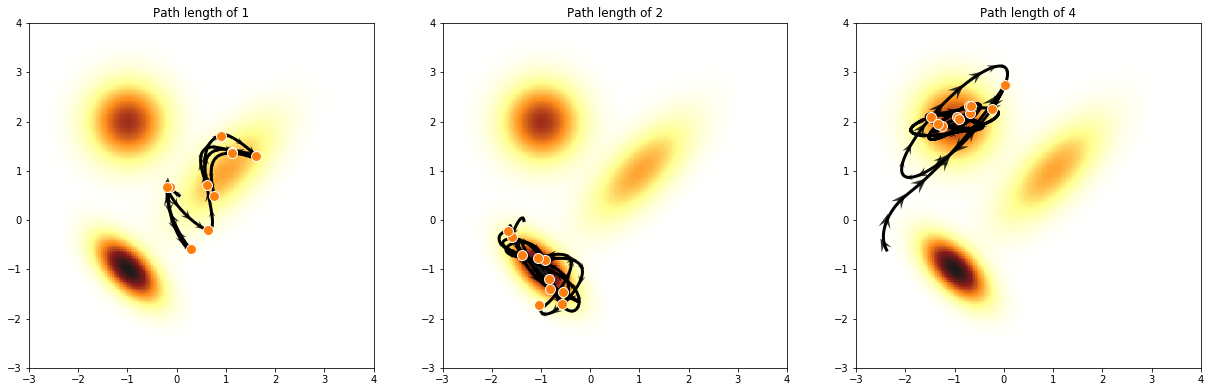

In [12]:
fig, axes = plt.subplots(ncols=len(ss), figsize=(7 * len(ss), 7))

Z, extent = neg_log_p_to_img(neg_log_p, (-3, 4, -3, 4), num=200)
steps = slice(None, None, 20)

for ax, samples, positions, momentums, path_len in zip(axes.ravel(), ss, pp, mm, pl):
    ax.imshow(Z, alpha=0.9, extent=extent, cmap='afmhot_r', origin='top')

    for q, p in zip(positions, momentums):
        ax.quiver(q[steps, 0], q[steps, 1], p[steps, 0], p[steps, 1], headwidth=6, scale=60, headlength=7, alpha=0.8)
        ax.plot(q[:, 0], q[:, 1], 'k-', lw=3)

    ax.plot(samples[:, 0], samples[:, 1], 'o', color='w', mfc='C1', ms=10)
    ax.set_title(f'Path length of {path_len}')


The HMC sampler can get into trouble, displaying pathologies with difficult model structures. For example, hierarchical models often feature relationships between the mixture scale parameter and individual parameters within the associated cluster. This results in a "funnel" distribution when plotted as a bivariate relationship. This geometry is hard for HMC to integrate, and results in divergences.

In [13]:
from minimc import neg_log_normal

def neg_log_funnel():
    scale = neg_log_normal(0, 1)
    def neg_log_p(x):
        funnel_dim = x.shape[0] - 1
        if funnel_dim == 1:
            funnel = neg_log_normal(0, np.exp(2 * x[0]))
        else:
            funnel = neg_log_mvnormal(np.zeros(funnel_dim), np.exp(2 * x[0]) * np.eye(funnel_dim))
        return scale(x[0]) + funnel(x[1:])
    return neg_log_p

In [14]:
from autograd import value_and_grad

In [15]:
value_and_grad(neg_log_p)(np.array([0., 2]))

(3.212624892569061, array([3.29105528, 0.02818537]))

In [16]:
np.random.seed(3)
neg_log_p = neg_log_funnel()
dVdq = grad(neg_log_p)


positions, momentums = [], []
for _ in range(3):
    q, p = np.random.randn(2, 2)
    _, _, q, p = leapfrog(q, p, dVdq, 4 * np.pi, 0.01)
    positions.append(q)
    momentums.append(p)

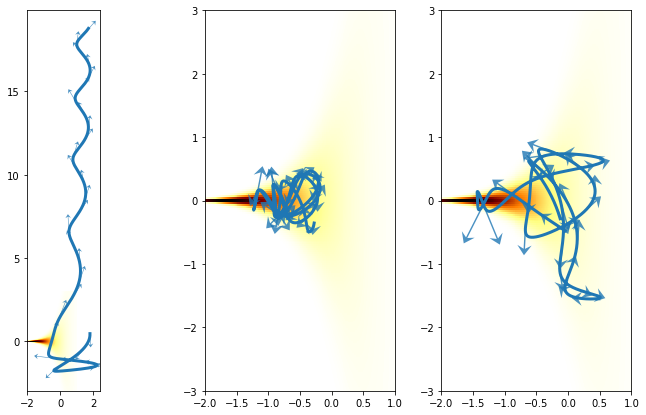

In [17]:
fig, axes = plt.subplots(ncols=len(positions), figsize=(4* len(positions), 7))


steps = slice(None, None, 40)

Z, extent = neg_log_p_to_img(neg_log_p, (-2, 1, -3, 3), num=200)

for idx, (ax, q, p) in enumerate(zip(axes.ravel(), positions, momentums)):
    ax.imshow(Z, alpha=1, extent=extent, cmap='afmhot_r', origin='top')

    ax.quiver(q[steps, 0], q[steps, 1], p[steps, 0], p[steps, 1], headwidth=10, scale=10, headlength=7, alpha=0.8, color='C0')
    ax.plot(q[:, 0], q[:, 1], '-', lw=3, color='C0')


___
## References

- **Neal, R. M. (2010)** [MCMC using Hamiltonian dynamics](http://www.mcmchandbook.net/HandbookChapter5.pdf), in the Handbook of Markov Chain Monte Carlo, S. Brooks, A. Gelman, G. L. Jones, and X.-L. Meng (editors), Chapman & Hall / CRC Press, pp. 113-162.
- **Christopher Bishop's "[Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book)"** A classic machine learning textbook, and gives a good overview of motivating sampling, as well as a number of different sampling strategies.
- **Iain Murray's [lectures at the MLSS](http://videolectures.net/mlss09uk_murray_mcmc/)** A good, approachable lecture, including intuition about how these algorithms are applied and implemented
- **Michael Betancourt's "[A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)"** A thorough, readable reference that is the main source here
- **Hoffman, M. D., and A. Gelman. (2014)**. “The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo.” Journal of Machine Learning Research: JMLR 15 (1): 1593–1623.